# ImportanceSampling-GaussianPosterior.ipynb
Importance sampling for a simple Gaussian posterior.

Model: $y\mid\theta \sim \mathcal{N}(\theta,1)$, $\theta\sim\mathcal{N}(0,10)$, with observed $y=3$.

True posterior mean: 2.727272727272727
True posterior sd: 0.9534625892455924
IS estimated mean: 2.7305411002134377
IS estimated variance: 0.9181710257544775
Effective Sample Size (ESS): 14170.416198029961
Saved figure to figs/IS_posterior_panels.png


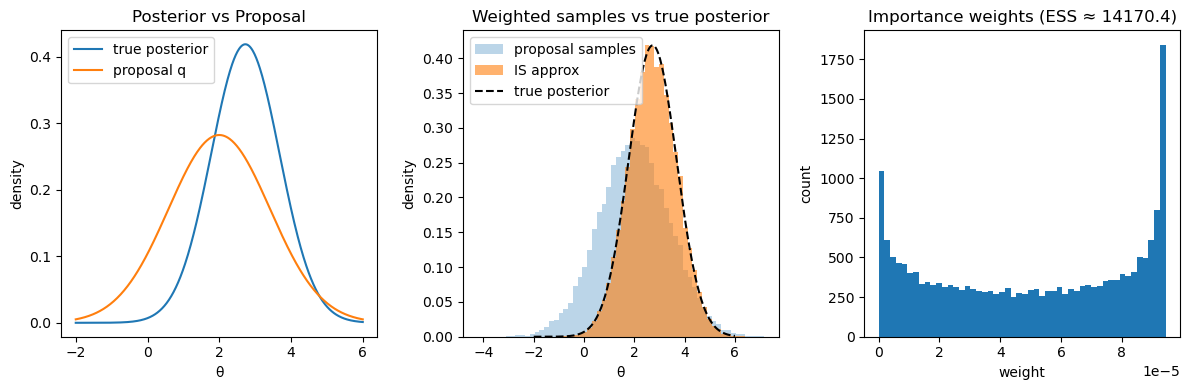

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

os.makedirs("figs", exist_ok=True)

# Data and prior
y = 3.0
prior = norm(loc=0.0, scale=np.sqrt(10.0))
likelihood_sd = 1.0

# True posterior is Gaussian (conjugate case)
posterior_var = 1.0 / (1.0/likelihood_sd**2 + 1.0/10.0)
posterior_sd = np.sqrt(posterior_var)
posterior_mean = posterior_var * (y/likelihood_sd**2 + 0.0/10.0)
posterior = norm(loc=posterior_mean, scale=posterior_sd)

print("True posterior mean:", posterior_mean)
print("True posterior sd:", posterior_sd)

# Proposal q(θ) = N(mu_q, sigma_q^2)
mu_q = 2.0
sigma_q = np.sqrt(2.0)
proposal = norm(loc=mu_q, scale=sigma_q)

def log_posterior_unnorm(theta):
    log_like = -0.5*((y - theta)/likelihood_sd)**2
    log_prior = -0.5*(theta**2/10.0)
    return log_like + log_prior

def log_proposal(theta):
    return proposal.logpdf(theta)

def importance_sampling(N, rng):
    theta = proposal.rvs(size=N, random_state=rng)
    log_w = log_posterior_unnorm(theta) - log_proposal(theta)
    # Avoid numerical overflow by subtracting max
    log_w -= np.max(log_w)
    w = np.exp(log_w)
    w /= np.sum(w)
    est_mean = np.sum(w * theta)
    est_var = np.sum(w * (theta - est_mean)**2)
    ess = 1.0 / np.sum(w**2)
    return theta, w, est_mean, est_var, ess

rng = np.random.default_rng(123)
N = 20000
theta, w, est_mean, est_var, ess = importance_sampling(N, rng)

print("IS estimated mean:", est_mean)
print("IS estimated variance:", est_var)
print("Effective Sample Size (ESS):", ess)

# Build panels figure
xs = np.linspace(-2, 6, 500)
plt.figure(figsize=(12, 4))

# Panel 1: true posterior vs proposal
plt.subplot(1, 3, 1)
plt.plot(xs, posterior.pdf(xs), label="true posterior")
plt.plot(xs, proposal.pdf(xs), label="proposal q")
plt.title("Posterior vs Proposal")
plt.xlabel("θ")
plt.ylabel("density")
plt.legend()

# Panel 2: weighted histogram vs posterior
plt.subplot(1, 3, 2)
plt.hist(theta, bins=60, density=True, alpha=0.3, label="proposal samples")
plt.hist(theta, bins=60, density=True, weights=w, alpha=0.6, label="IS approx")
plt.plot(xs, posterior.pdf(xs), "k--", label="true posterior")
plt.title("Weighted samples vs true posterior")
plt.xlabel("θ")
plt.ylabel("density")
plt.legend()

# Panel 3: weights and ESS
plt.subplot(1, 3, 3)
plt.hist(w, bins=50)
plt.title(f"Importance weights (ESS ≈ {ess:.1f})")
plt.xlabel("weight")
plt.ylabel("count")

plt.tight_layout()
savepath = "figs/IS_posterior_panels.png"
plt.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()